# Модуль Г. Сетевой анализ данных (вариатив)

Краткое описание задания: выявление связей и взаимодействие между элементами, в том числе с использованием инструментов визуализации. Определение ключевых узлов и групп навыков. Предложение рекомендации на основе анализа данных.

# 1. Разделение датасета на две табллицы (узлы и рёбра)

Чтобы построить граф связей навыков, нужно создать два списка: узлы (nodes) и связи (edges). Узлы будут представлять собой отдельные навыки, а связи будут показывать, как часто два навыка упоминаются вместе в одной вакансии.

Процесс будет включать следующие шаги:

1. Извлечь список навыков из вакансий.
2. Подсчитать количество совместных упоминаний для каждой пары навыков.
3. Создать файлы nodes и edges для импорта в Gephi.

Для начала загрузим необходимые библиотеки и датасет с вакансиями.

In [1]:
import pandas as pd
from itertools import combinations
from collections import Counter

In [2]:
data = pd.read_excel('data_clustered.xlsx')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7404 entries, 0 to 7403
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             7404 non-null   object
 1   company        7404 non-null   object
 2   name           7404 non-null   object
 3   description    7403 non-null   object
 4   skills         7404 non-null   object
 5   date_public    7404 non-null   object
 6   schedule       7404 non-null   object
 7   region         7404 non-null   object
 8   experience     7404 non-null   object
 9   salary         7404 non-null   int64 
 10  prep_text      7404 non-null   object
 11  tokenize_text  7404 non-null   object
 12  text_stem      7404 non-null   object
 13  text_lemm      7404 non-null   object
 14  sentiment      7404 non-null   object
 15  cluster        7404 non-null   int64 
dtypes: int64(2), object(14)
memory usage: 925.6+ KB


In [19]:
data.head()

,id,company,name,description,skills,date_public,schedule,region,experience,salary,prep_text,tokenize_text,text_stem,text_lemm,sentiment,cluster
0,73013752,Не указано,Аналитик в планово-диспетчерский отдел,"Обязанности: Расчет, формирование , контроль ...",Пользователь ПК; Электронный документооборот; ...,2024-04-05T08:55:42+0300,Полный день,Москва,От 1 года до 3 лет,116000,пользователь пк электронный документооборот ра...,Пользователь ПК ; Электронный документооборот ...,пользовател пк ; электрон документооборот ; ра...,пользователь пк ; электронный документооборот ...,"{'neg': 0.0, 'neu': 0.943, 'pos': 0.057, 'comp...",0
1,76533535,Не указано,Аналитик в команду внедрения ботов,Banks Soft Systems - это ведущий разработчик в...,Написание сценариев; Разработка технических за...,2024-03-25T11:07:32+0300,Удаленная работа,Москва,От 1 года до 3 лет,0,написание сценариев разработка технических зад...,Написание сценариев ; Разработка технических з...,написан сценар ; разработк техническ задан ; P...,написание сценарий ; разработка технический за...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2
2,77195081,Не указано,Системный аналитик в IT Компанию РОЛЬФТЕХ (уда...,Наша команда расширяется и мы находимся в поис...,Не указано,2024-04-17T09:34:24+0300,Полный день,Москва,От 1 года до 3 лет,0,не указано,Не указано,не указа,указать,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1
3,77538397,"Компания «СПОРТМАСТЕР», Офис",Бизнес-аналитик,«Спортмастер» — это международный спортивный р...,MS Visio; Business Studio; MS PowerPoint; Опти...,2024-03-27T09:32:37+0300,Полный день,Москва,От 1 года до 3 лет,0,ms visio business studio ms powerpoint оптимиз...,MS Visio ; Business Studio ; MS PowerPoint ; О...,MS Visio ; Business Studio ; MS PowerPoint ; о...,ms visio ; business studio ; ms powerpoint ; о...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2
4,81311010,ДИКСИ. IT,Разработчик-аналитик SQL (Junior),"Функции: Разработка SSRS, SSAS отчетности Соз...",Python; SQL; SSIS; MS SQL Server; C#; SSAS; SS...,2024-03-22T12:42:39+0300,Удаленная работа,Москва,От 3 до 6 лет,0,python sql ssis ms sql server c ssas ssrs powe...,Python ; SQL ; SSIS ; MS SQL Server ; C # ; SS...,Python ; SQL ; SSIS ; MS SQL Server ; C # ; SS...,python ; sql ; ssis ; ms sql server ; c # ; ss...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",3


После загрузки датасета можно приступить к выполнению указаных шагов (для удобства можно ориентироваться на комментарии в коде)

In [ ]:
# Фильтруем данные для вакансий с cluster = 4
cluster_4_data = data[data['cluster'] == 4]

# Извлекаем колонку 'skills' и фильтруем строки с 'Не указано'
skills_series = cluster_4_data['skills'].dropna()
skills_series = skills_series[skills_series != 'Не указано']

# Приводим все навыки к нижнему регистру
skills_series = skills_series.str.lower()

# Удаляем все пробелы между ";"
skills_series = skills_series.str.replace(r'\s*;\s*', ';', regex=True)

# Разделяем навыки по ';' и создаем список списков
skills_list = skills_series.apply(lambda x: x.split(';')).tolist()

# Генерируем все пары навыков для каждой вакансии
skill_pairs = []
for skills in skills_list:
    skill_pairs.extend(combinations(sorted(skills), 2))

# Считаем количество каждого навыка и каждой пары навыков
skill_count = Counter(skill for skills in skills_list for skill in skills)
pair_count = Counter(skill_pairs)

# Подготавливаем узлы и ребра для Gephi
nodes = [{'id': skill, 'label': skill, 'weight': count} for skill, count in skill_count.items()]
edges = [{'source': pair[0], 'target': pair[1], 'weight': count} for pair, count in pair_count.items()]

# Конвертируем в DataFrame
nodes_df = pd.DataFrame(nodes)
edges_df = pd.DataFrame(edges)

# Сортируем DataFrame по weight в порядке убывания
nodes_df = nodes_df.sort_values(by='weight', ascending=False)
edges_df = edges_df.sort_values(by='weight', ascending=False)

# Выводим первые несколько строк для проверки
print(nodes_df.head())
print(edges_df.head())

In [4]:
nodes_df.head(10)

,id,label,weight
72,1с: erp,1с: erp,382
133,формирование технических заданий,формирование технических заданий,205
0,1с: предприятие,1с: предприятие,166
52,1с: бухгалтерия,1с: бухгалтерия,136
53,1с: зарплата и управление персоналом,1с: зарплата и управление персоналом,126
134,управление персоналом,управление персоналом,102
38,1с: документооборот,1с: документооборот,94
70,1с: управление торговлей,1с: управление торговлей,89
140,работа с erp-системами,работа с erp-системами,87
71,аналитическое мышление,аналитическое мышление,78


In [5]:
edges_df.head(10)

,source,target,weight
982,1с: erp,формирование технических заданий,210
980,1с: erp,1с: erp,168
351,1с: erp,1с: предприятие,155
978,управление персоналом,формирование технических заданий,153
981,1с: erp,управление персоналом,108
1000,1с: erp,организация и управление бизнес-процессами,107
975,1с: предприятие,формирование технических заданий,105
1051,1с: erp,работа с erp-системами,91
1028,1с: erp,1с: бухгалтерия,89
1030,1с: erp,ведение бухгалтерского учета,83


Теперь у нас есть два необходимых датафрейма: nodes_df и edges_df, которые содержат информацию об узлах и связях соответственно. Давайте сохраним их в файлы, которые можно будет импортировать в Gephi.

- nodes_df будет содержать столбцы id, label и weight.
- edges_df будет содержать столбцы source, target и weight.

In [7]:
# Сохраняем таблицу с частотой, содержанием и классом навыков в файл Excel с учетом кодировки
nodes_df.to_csv('nodes.csv', index=False)
edges_df.to_csv('edges.csv', index=False)

Файлы готовы для импорта в Gephi

# 2. Граф в Gephi (визуализация групп навыков)

В результате после импорта узлов и рёбер, а также небольшой настройки, получился вот такой граф:

Скрин с полным масштабом (полный)

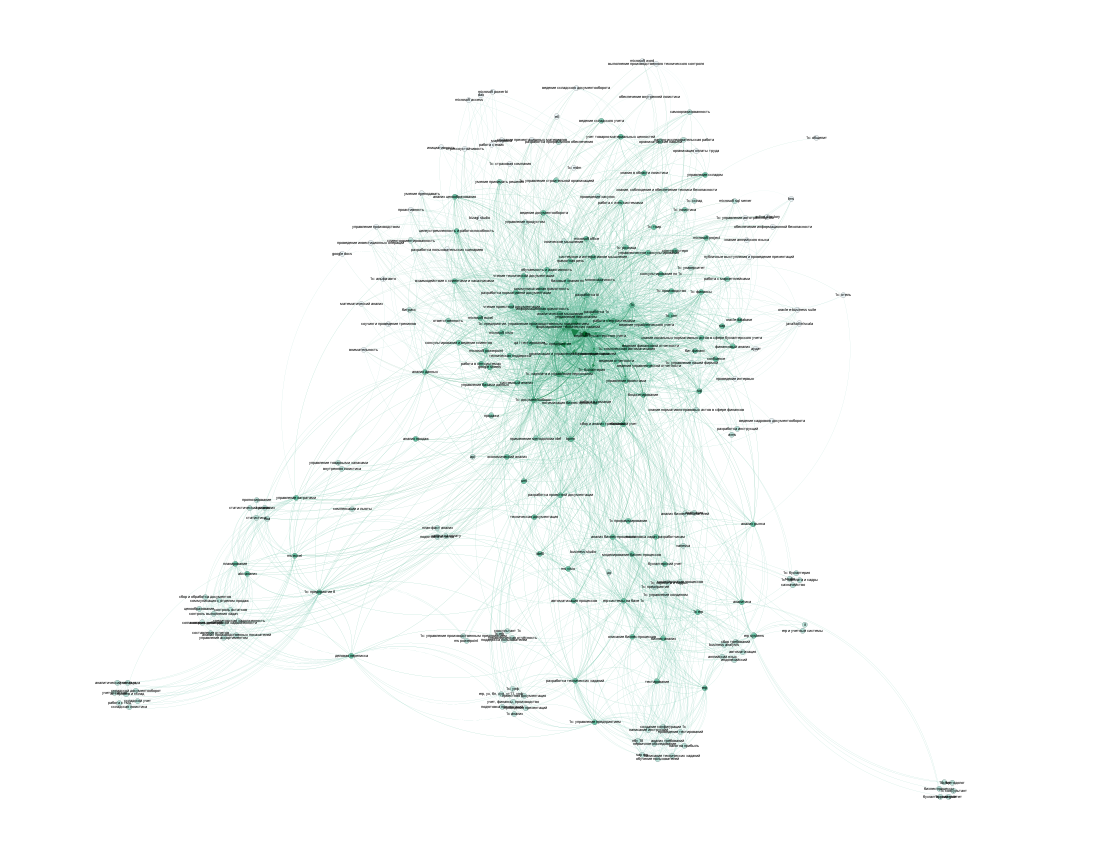

Скрин с близким масштабом (увеличен)

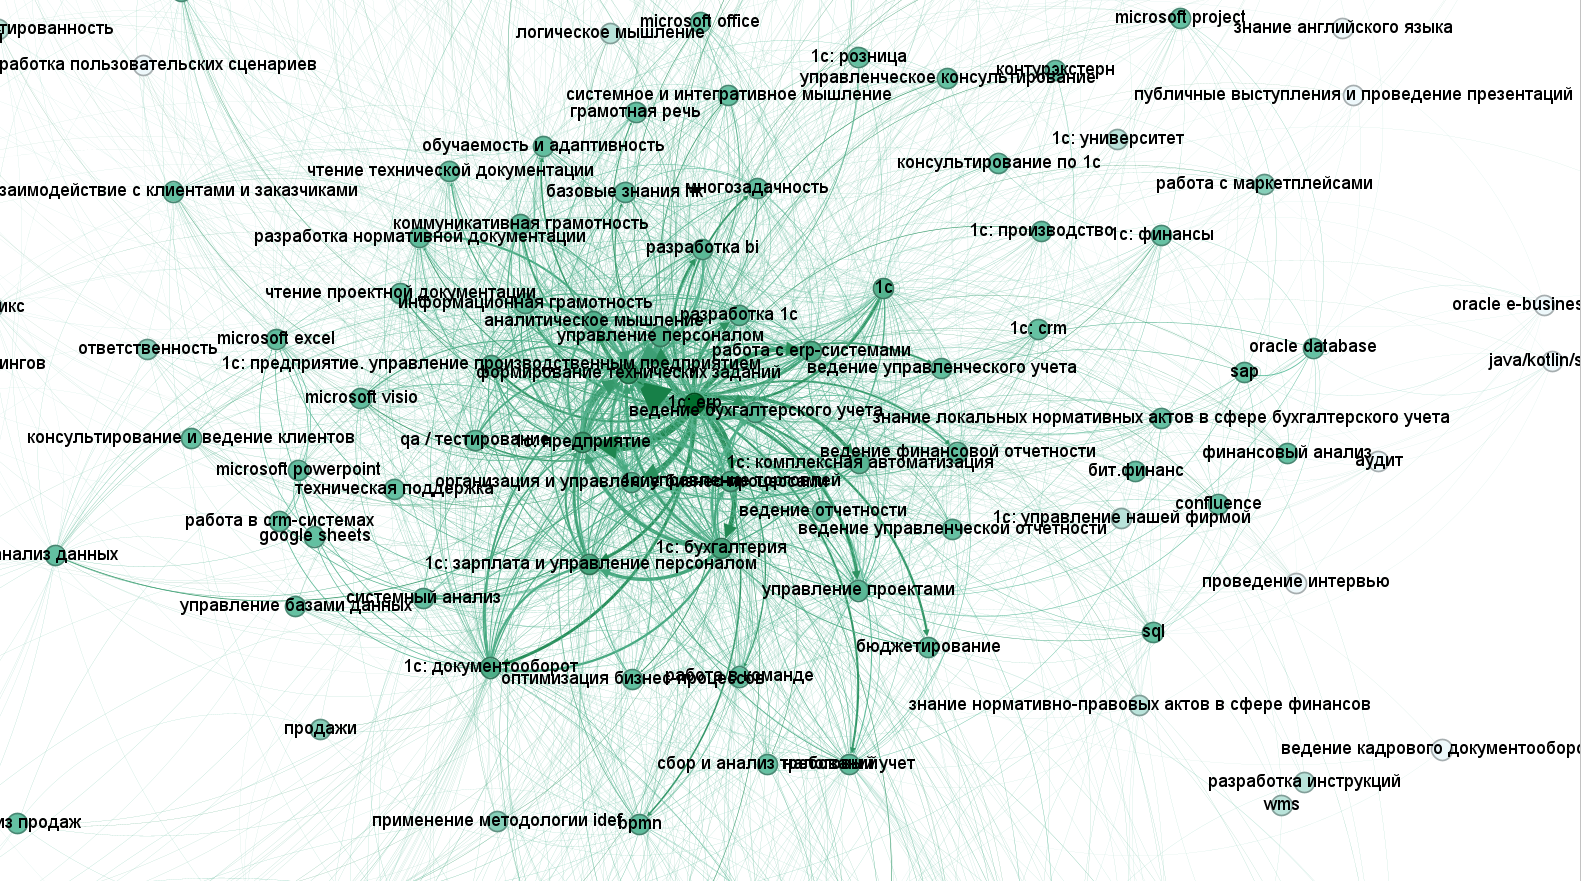

**Всего узлов** - 253

**Всего рёбер** - 2811

Данный граф изображает связи навыков по группе вакансий, которая связана с 1С разработкой.

Чем больше встречался данный навык - тем зеленее (темнее) он будет. Чем больше у этого навыка связи с другим навыком - тем больше стрелка.

Можно заметить что в центре графа оказался навык 1c:erp, также можно заметить что у этого навыка самый зелёный цвет, это говорит нам о том, что этот навык встречался больше остальных навыкров. А так же по размерам стрелок можно заметить что пара навыков 1c:erp и формирование технических заданий имеет самую сильную связь, т.к. у этой связи самая большая стрелка. Чем ближе остальные навыки к основнным (1c:erp и др.), тем чаще этот навык встречается и имеет больше связей. Видно что по краям графа расположены навыки с самым прозрачным цветом зелёного, что говорит нам о редкости встречаемости данных навыков, а также тонкие стрелки, что говорит нам о незначительных связях с другими навыками.

# 3. Основные метрики

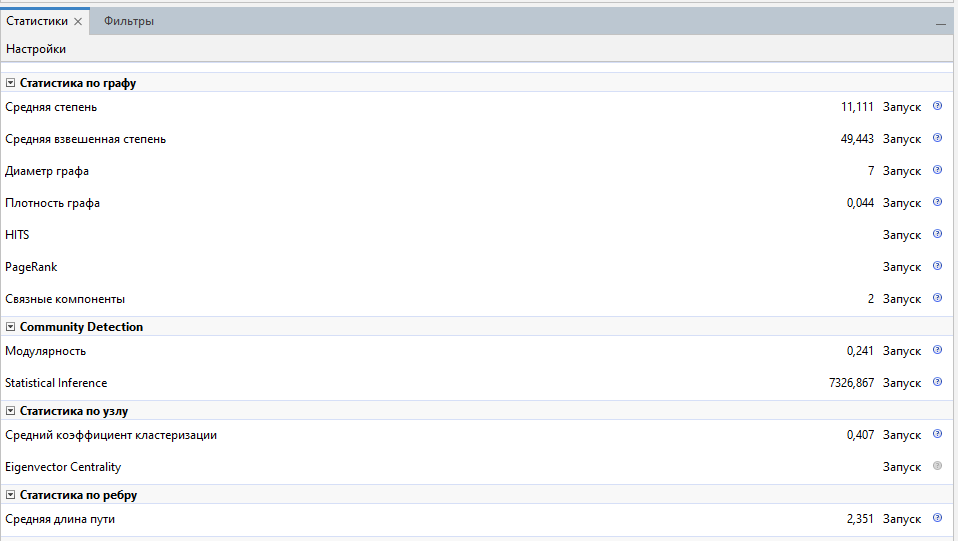

**Средняя степень (Average Degree): 11.111**
Значение: Среднее количество связей на один узел. Высокое значение средней степени указывает на то, что узлы в графе, в среднем, сильно связаны.

**Средняя взвешенная степень (Average Weighted Degree): 49.443**
Значение: Среднее количество взвешенных связей на один узел. Взвешенная степень учитывает частоту упоминания навыков вместе.

**Диаметр графа (Graph Diameter): 7**
Значение: Максимальная длина кратчайшего пути между любыми двумя узлами. Показывает наибольшее расстояние между двумя узлами в графе.

**Плотность графа (Graph Density): 0.044**
Значение: Отношение числа существующих рёбер к максимально возможному числу рёбер. Низкая плотность указывает на то, что большинство возможных связей между узлами отсутствуют.

**Связные компоненты (Connected Components): 2**
Значение: Количество связных подграфов внутри основного графа. Две связные компоненты означают, что граф состоит из двух независимых подграфов.

**Модульность (Modularity): 0.241**
Значение: Мера структуры сети, которая оценивает степень разделения сети на модули или сообщества. Значение модульности указывает на наличие некоторых кластеров или сообществ внутри графа.

**Средний коэффициент кластеризации (Average Clustering Coefficient): 0.407**
Значение: Вероятность того, что два соседних узла также связаны между собой. Высокий коэффициент кластеризации указывает на наличие кластеров или групп узлов, которые сильно связаны между собой.

**Средняя длина пути (Average Path Length): 2.351**
Значение: Средняя длина кратчайших путей между всеми парами узлов. Это значение указывает на то, насколько тесно связаны узлы в графе в среднем.

Эти метрики дают общее представление о структуре и свойствах графа навыков. Высокая средняя степень и взвешенная степень указывают на сильные связи между навыками, тогда как низкая плотность и несколько связных компонентов указывают на разобщённость графа. Модульность и средний коэффициент кластеризации подчеркивают наличие кластеров или сообществ навыков.

# 4. Рекомендации

Стоит обратить внимание на навыки, которые чаще всего встречаются в вакансиях 1С разработчика. На основе графа можно выделить следующие часто встречающиеся навыки: 1c:erp, формирование технических заданий, 1c: предприятие, 1c: бухгалтерия, 1с: зарплата и управление персоналом, управление персоналом, 1с: документооборот, 1с: управление торговлей.

Также стоит обратить внимание на навыки, которые имеют сильную связь с основными навыками. На основе графа можно выделить следующие самые сильные связи навыков: 1c:erp и формирование технических заданий, 1c:erp и 1c: предприятие, управление персоналом и формирование технических заданий, 1c:erp и управление персоналом.

Основные понятия и данные к графу предоставлены, так что тот кто изучает сферу 1С разработки может ориентироваться на данный граф и постепенно изучать данные навыки от большего к меньшему.